In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 2
selected_ev            = 3;      # which Eigenvector to choose
ϵ                      = 0.5     # perturbation
a                      = 0.98;   # parameter value corresponding to ϵ=0

In [4]:
T(x,p) = [rem2pi(x[1] + x[2] + (a+p)*sin(x[1]), RoundDown),
          rem2pi(       x[2] + (a+p)*sin(x[1]), RoundDown)]

T (generic function with 1 method)

In [5]:
LL, UR = (0.0, 0.0), (2π, 2π)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order)
pred(x,y) = peuclidean(x, y, [2π, 2π]) < 1e-9
bdata = BoundaryData(ctx, pred);

In [6]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [7]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

  2.453999 seconds (13.17 M allocations: 561.267 MiB, 4.76% gc time)


In [8]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata);

9801×9801 SparseArrays.SparseMatrixCSC{Float64,Int64} with 68607 stored entries:
  [1   ,    1]  =  -8.37786
  [2   ,    1]  =  -0.479007
  [3   ,    1]  =  2.68893
  [197 ,    1]  =  -0.479007
  [198 ,    1]  =  1.97901
  [9703,    1]  =  2.68893
  [9704,    1]  =  1.97901
  [1   ,    2]  =  -0.479007
  [2   ,    2]  =  -8.36026
  [3   ,    2]  =  1.97901
  [4   ,    2]  =  2.68013
  [5   ,    2]  =  -0.473051
  ⋮
  [195 , 9800]  =  2.65387
  [9701, 9800]  =  2.65387
  [9702, 9800]  =  1.97305
  [9799, 9800]  =  -0.461164
  [9800, 9800]  =  -8.30775
  [9801, 9800]  =  -0.473051
  [195 , 9801]  =  1.97305
  [197 , 9801]  =  2.68013
  [9604, 9801]  =  1.97901
  [9702, 9801]  =  2.68013
  [9703, 9801]  =  -0.479007
  [9800, 9801]  =  -0.473051
  [9801, 9801]  =  -8.36026

In [9]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

  2.479824 seconds (17.01 M allocations: 830.527 MiB, 5.85% gc time)


In [10]:
# solve the linear system
@time λ₀s, u₀s = eigs(K, M, which=:SM)
@assert all(imag.(u₀s) .== 0)
@assert all(imag.(λ₀s) .== 0)
u₀s = real.(u₀s)
λ₀s = real.(λ₀s)
# normalize
for i in 1:size(u₀s)[2]
    u₀s[:,i] = u₀s[:,i] ./ sqrt(u₀s[:,i]'*M*u₀s[:,i])
    u₀s[:,i] = u₀s[:,i]*sign(sum(u₀s[:,i]))
end

  2.988489 seconds (9.32 M allocations: 542.784 MiB, 4.15% gc time)


In [11]:
# calculate the exact uϵ
λϵs, uϵs = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵs) .== 0)
@assert all(imag.(λϵs) .== 0)
uϵs = real.(uϵs)
λϵs = real.(λϵs)
# normalize
for i in 1:size(uϵs)[2]
    uϵs[:,i] = uϵs[:,i] ./ sqrt(uϵs[:,i]'*M*uϵs[:,i])
    uϵs[:,i] = uϵs[:,i]*sign(sum(uϵs[:,i]))
end

In [12]:
# solve the system for the derivative u_dot
u_dots = []
λ_dots = []
for i in 1:size(u₀s)[2] 
    lhs = [K-λ₀s[i]*M   -M*u₀s[:,i]
            u₀s[:,i]'*M      0]
    rhs = [-L*u₀s[:,i]    ;  0]

    @time b = lhs \ rhs
    push!(u_dots,b[1:end-1])
    push!(λ_dots,b[end])
end

  0.698380 seconds (2.45 M allocations: 141.337 MiB, 5.17% gc time)
  0.057839 seconds (75 allocations: 23.459 MiB)
  0.082682 seconds (65.70 k allocations: 27.093 MiB, 11.06% gc time)
  0.057563 seconds (75 allocations: 23.459 MiB)
  0.068417 seconds (79 allocations: 23.459 MiB, 10.36% gc time)
  0.057023 seconds (75 allocations: 23.459 MiB)


In [25]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -0.5
cmax =     0.5
cmin_lr =  -0.5
cmax_lr =  0.5

0.5

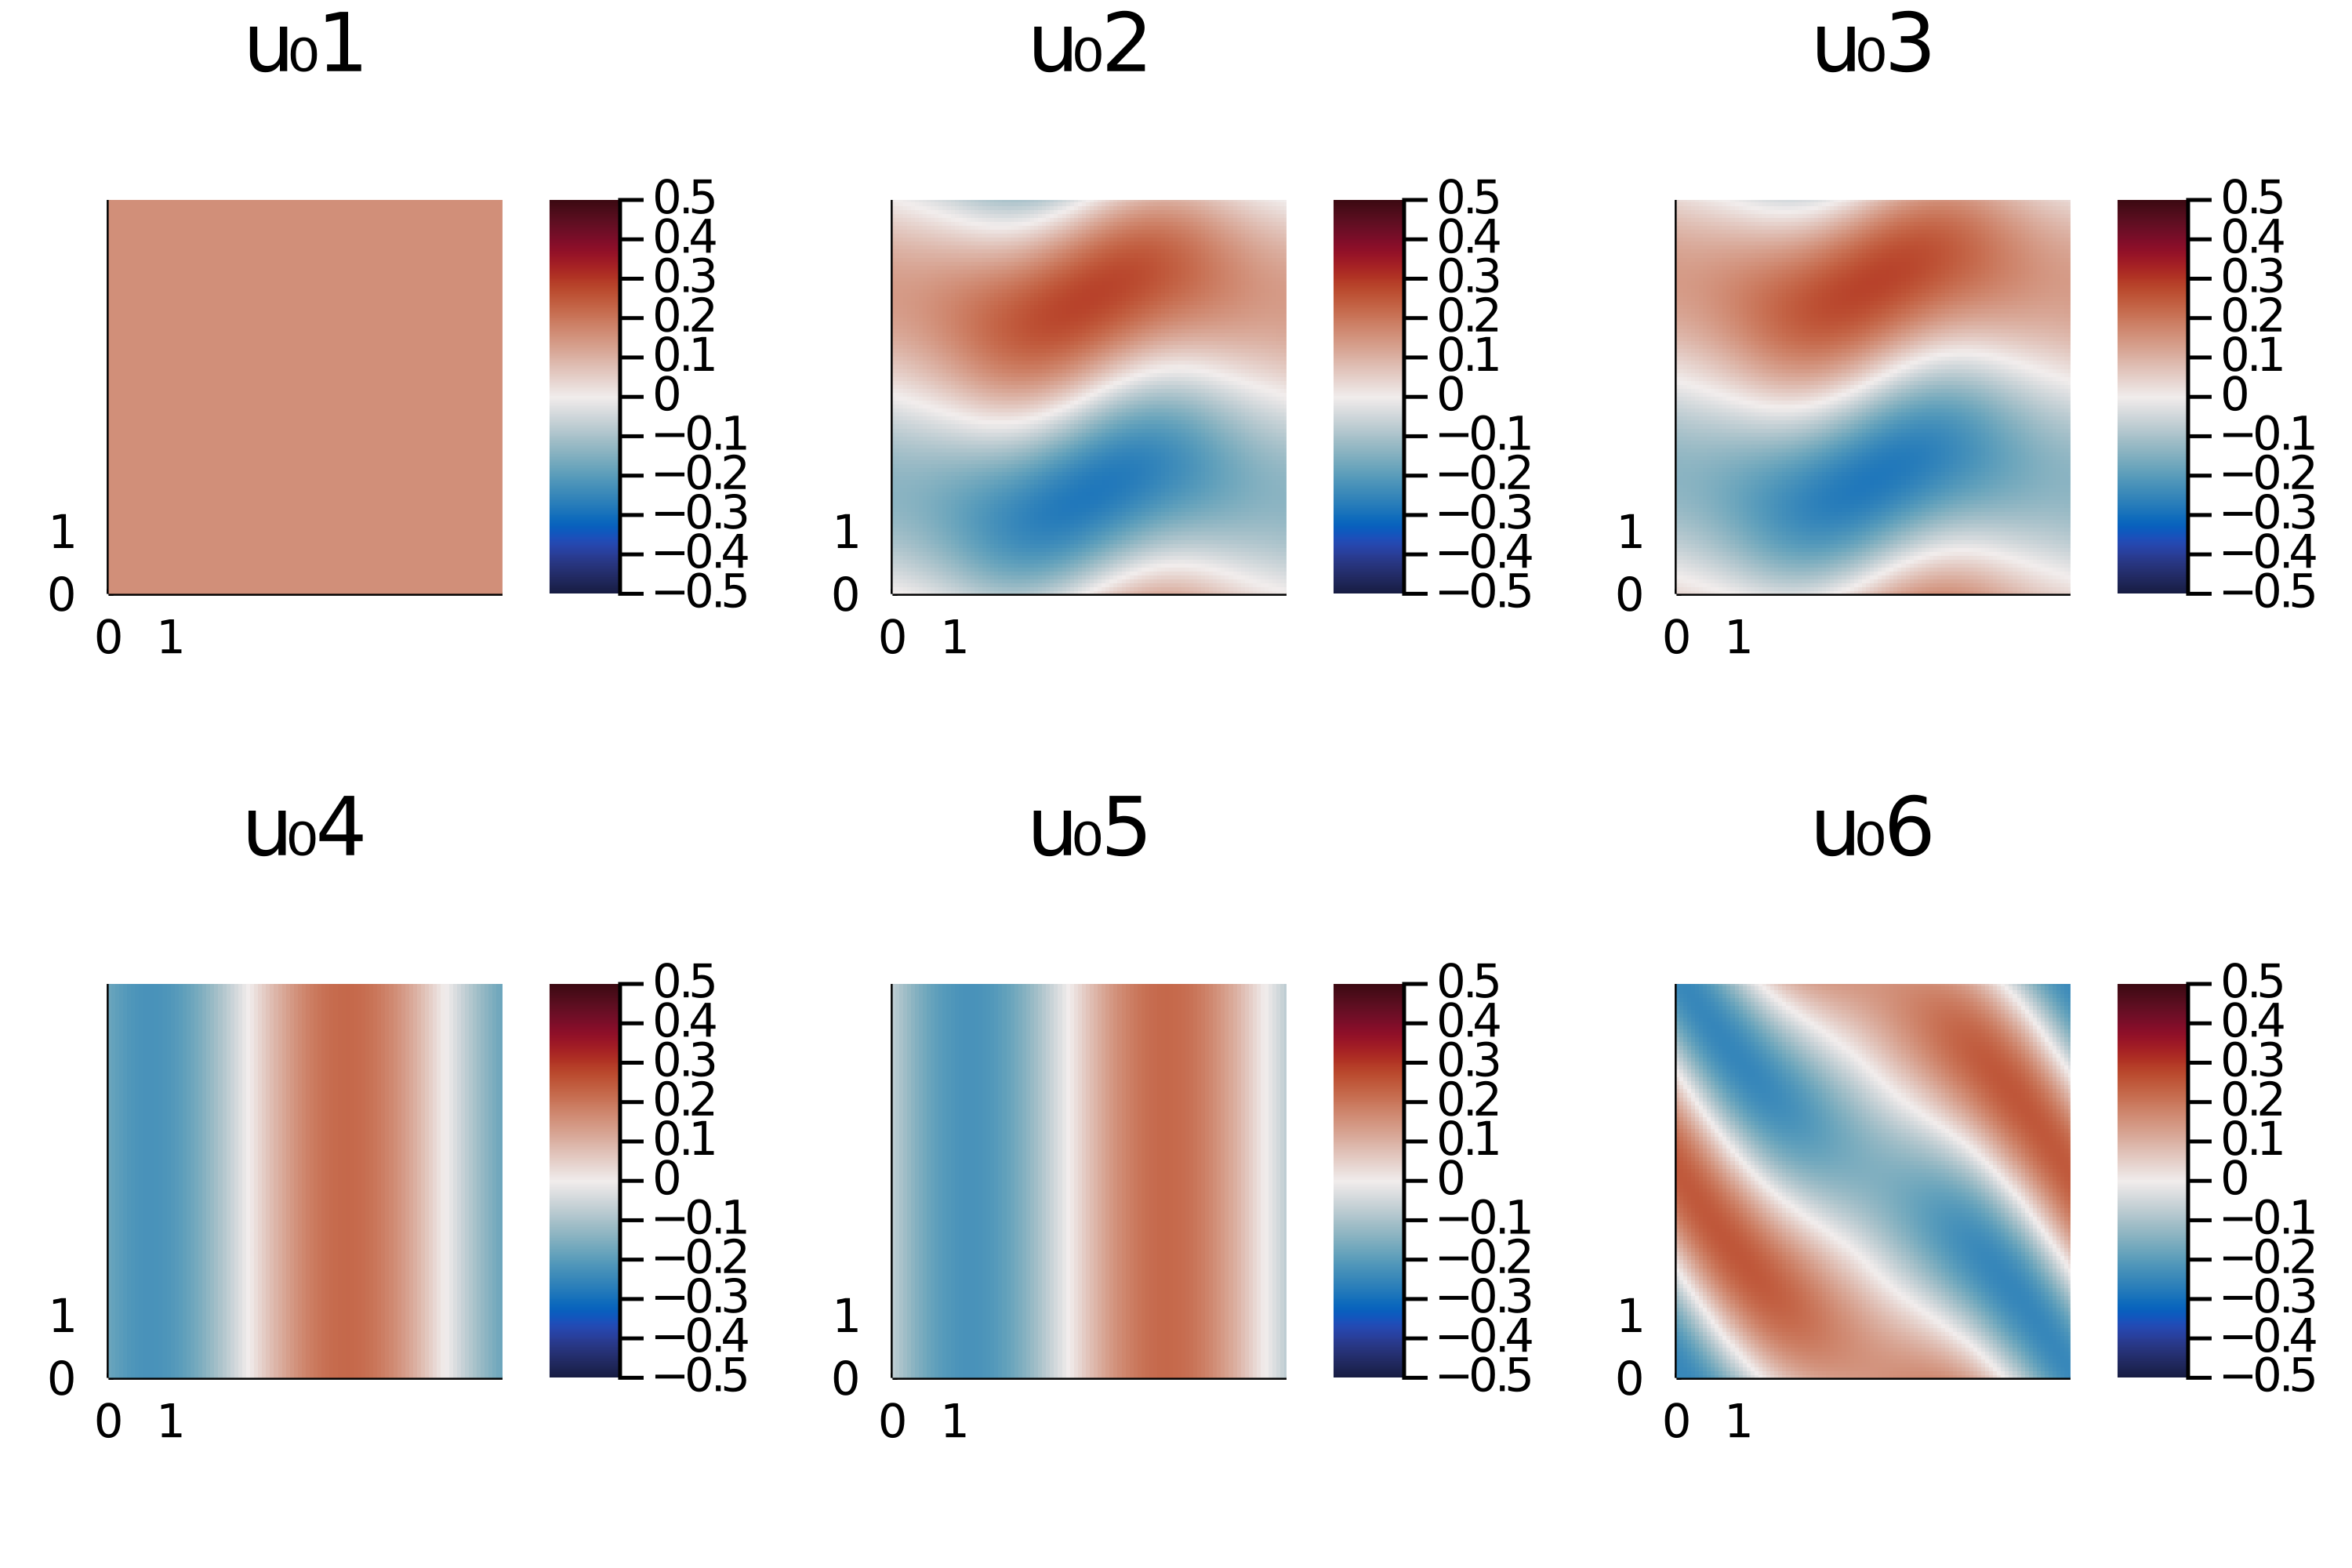

In [26]:
first         = plot_u(ctx, u₀s[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, u₀s[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, u₀s[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, u₀s[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, u₀s[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, u₀s[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

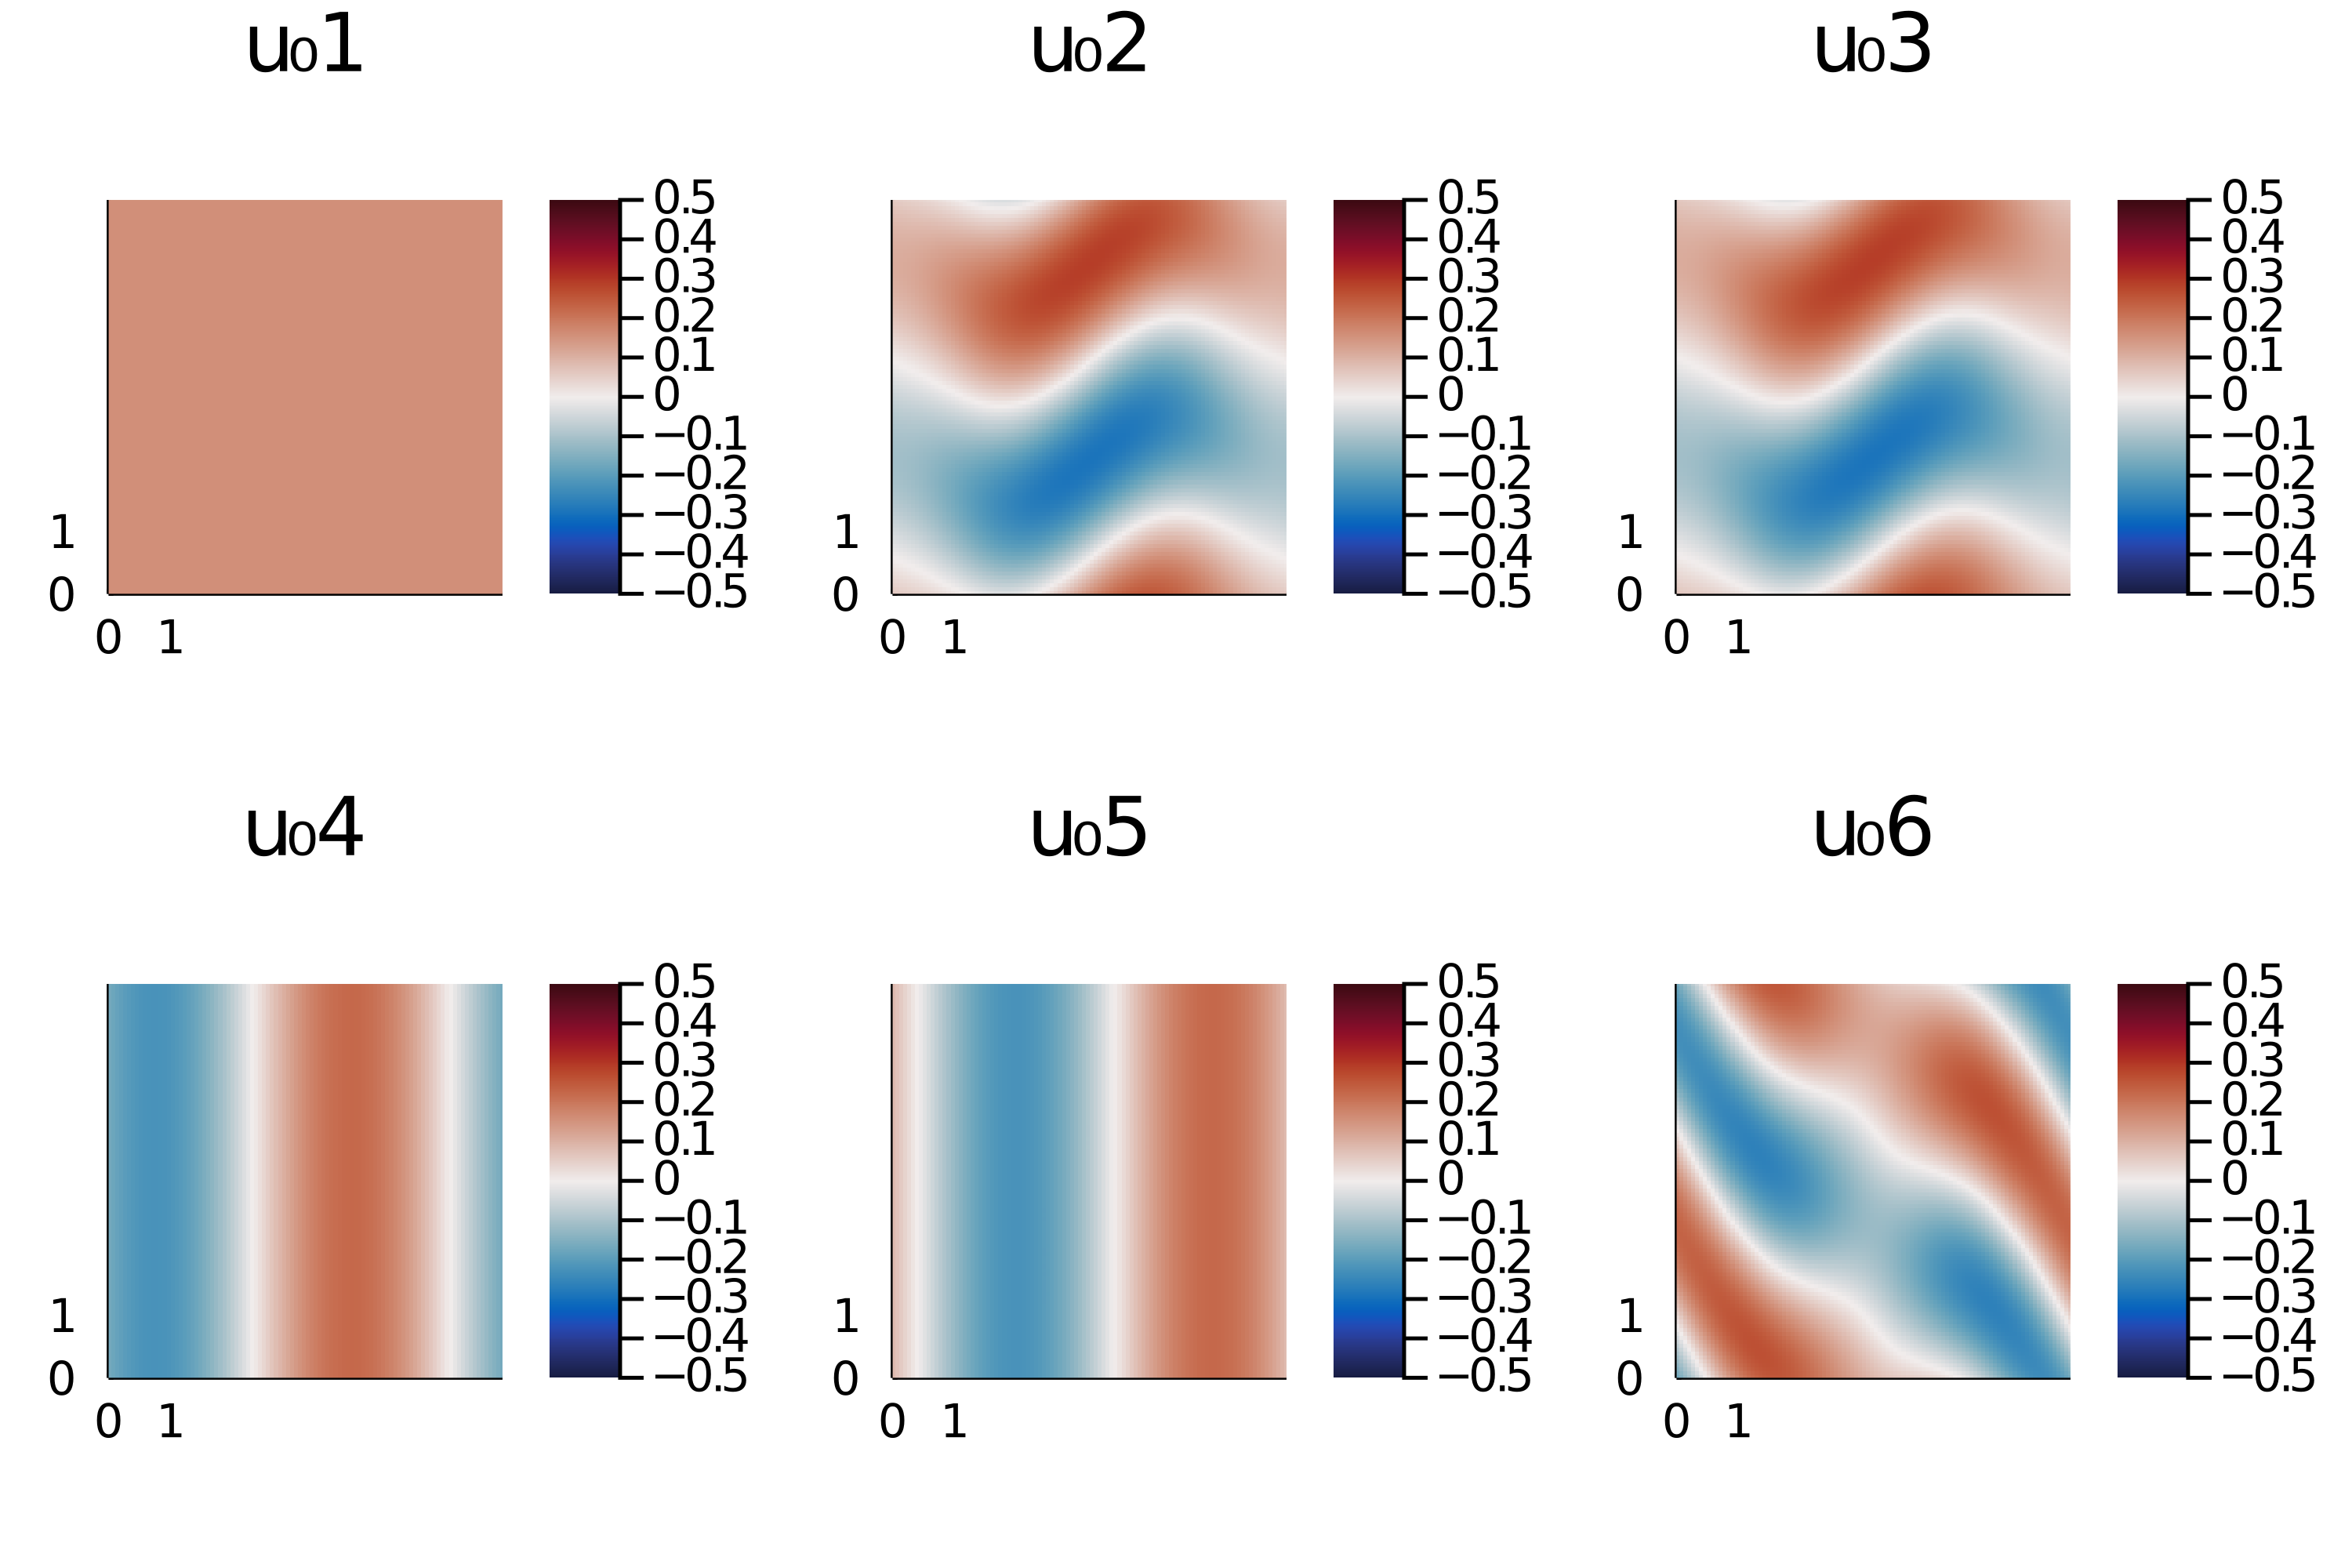

In [27]:
first         = plot_u(ctx, uϵs[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, uϵs[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, uϵs[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, uϵs[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, uϵs[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, uϵs[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

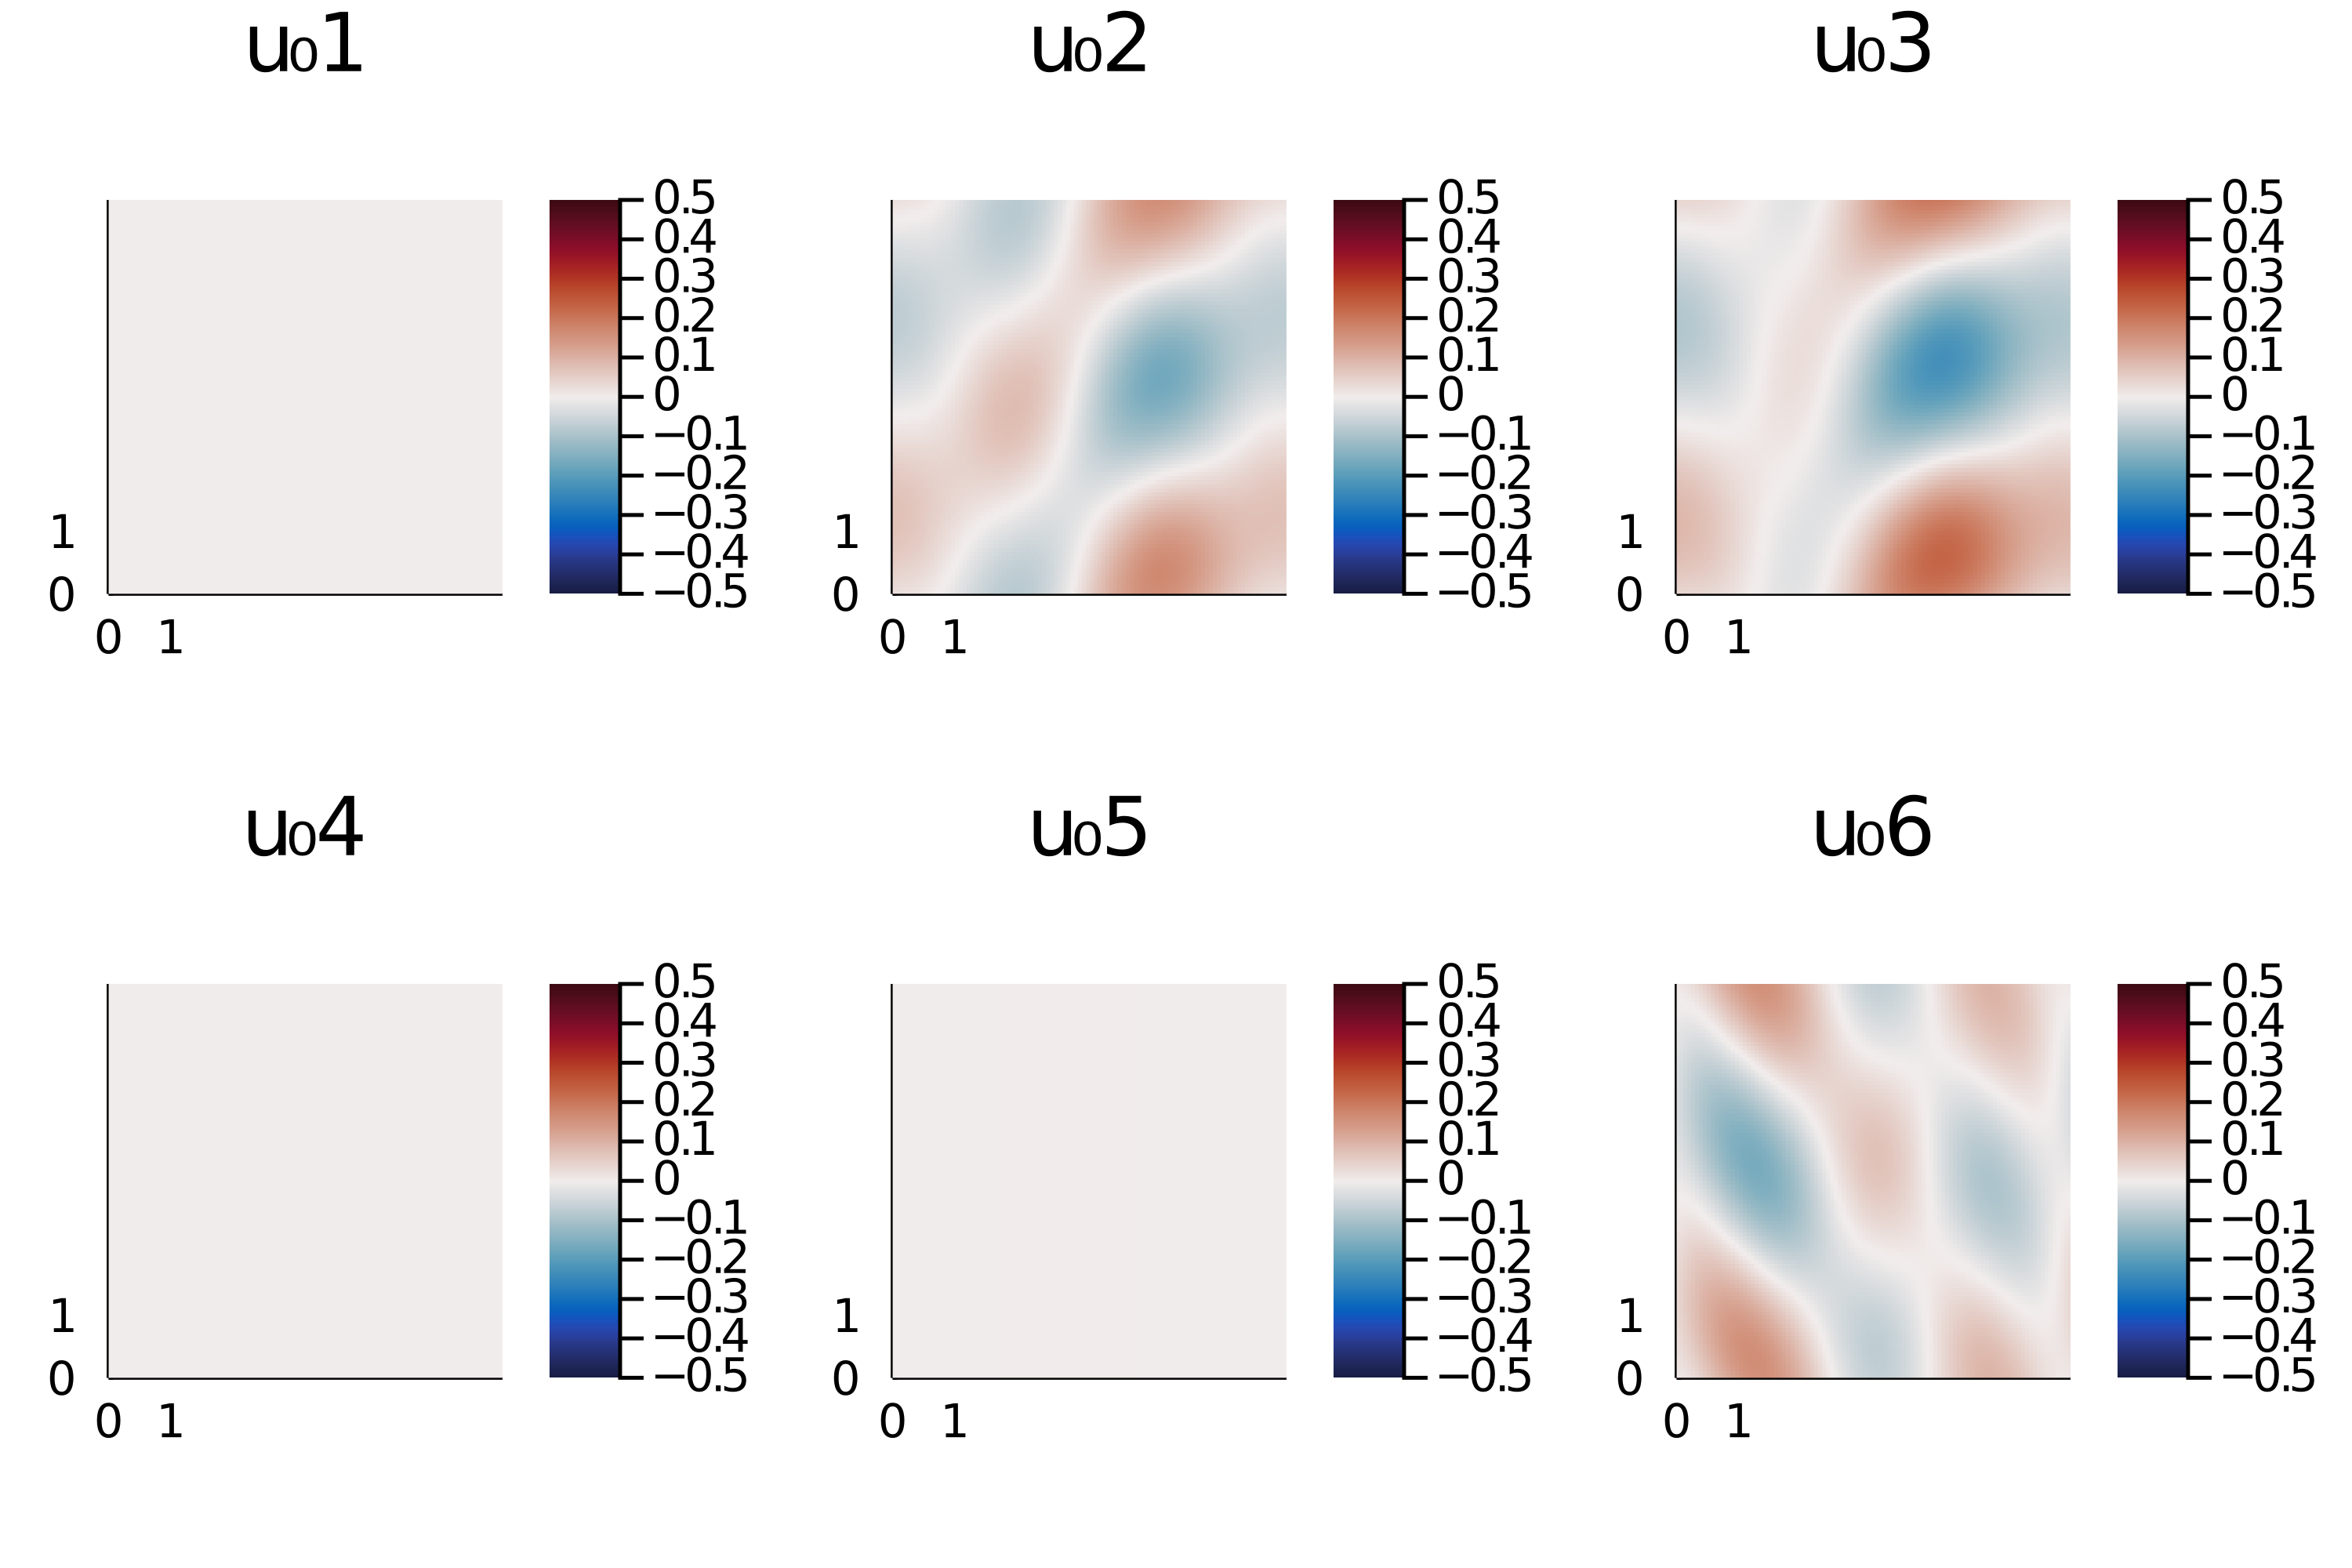

In [28]:
first         = plot_u(ctx, u_dots[1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, u_dots[2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, u_dots[3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, u_dots[4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, u_dots[5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, u_dots[6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

In [17]:
S = SEBA(u₀s)

9801×6 Array{Float64,2}:
  0.0  -0.0  -0.0  -0.0  0.127573   0.683716
  0.0  -0.0  -0.0  -0.0  0.154816   0.667735
  0.0  -0.0  -0.0  -0.0  0.111637   0.699497
  0.0  -0.0  -0.0  -0.0  0.136404   0.680474
  0.0  -0.0  -0.0  -0.0  0.178677   0.646588
  0.0  -0.0  -0.0  -0.0  0.157776   0.656277
  0.0  -0.0  -0.0  -0.0  0.199044   0.62038
  0.0  -0.0  -0.0  -0.0  0.175615   0.627091
  0.0  -0.0  -0.0  -0.0  0.215756   0.589379
  0.0  -0.0  -0.0  -0.0  0.189809   0.593178
  0.0  -0.0  -0.0  -0.0  0.228771   0.553822
  0.0  -0.0  -0.0  -0.0  0.20031    0.554831
  0.0  -0.0  -0.0  -0.0  0.238054   0.514043
  ⋮                                 ⋮
 -0.0   0.0  -0.0   0.0  0.0        0.436872
 -0.0  -0.0  -0.0   0.0  0.0        0.478121
 -0.0  -0.0  -0.0   0.0  0.0        0.516424
 -0.0  -0.0  -0.0   0.0  0.0        0.551386
 -0.0  -0.0  -0.0   0.0  0.0        0.582648
 -0.0  -0.0  -0.0   0.0  0.0        0.609844
 -0.0  -0.0  -0.0   0.0  0.0        0.63268
 -0.0  -0.0  -0.0   0.0  0.0        0.6

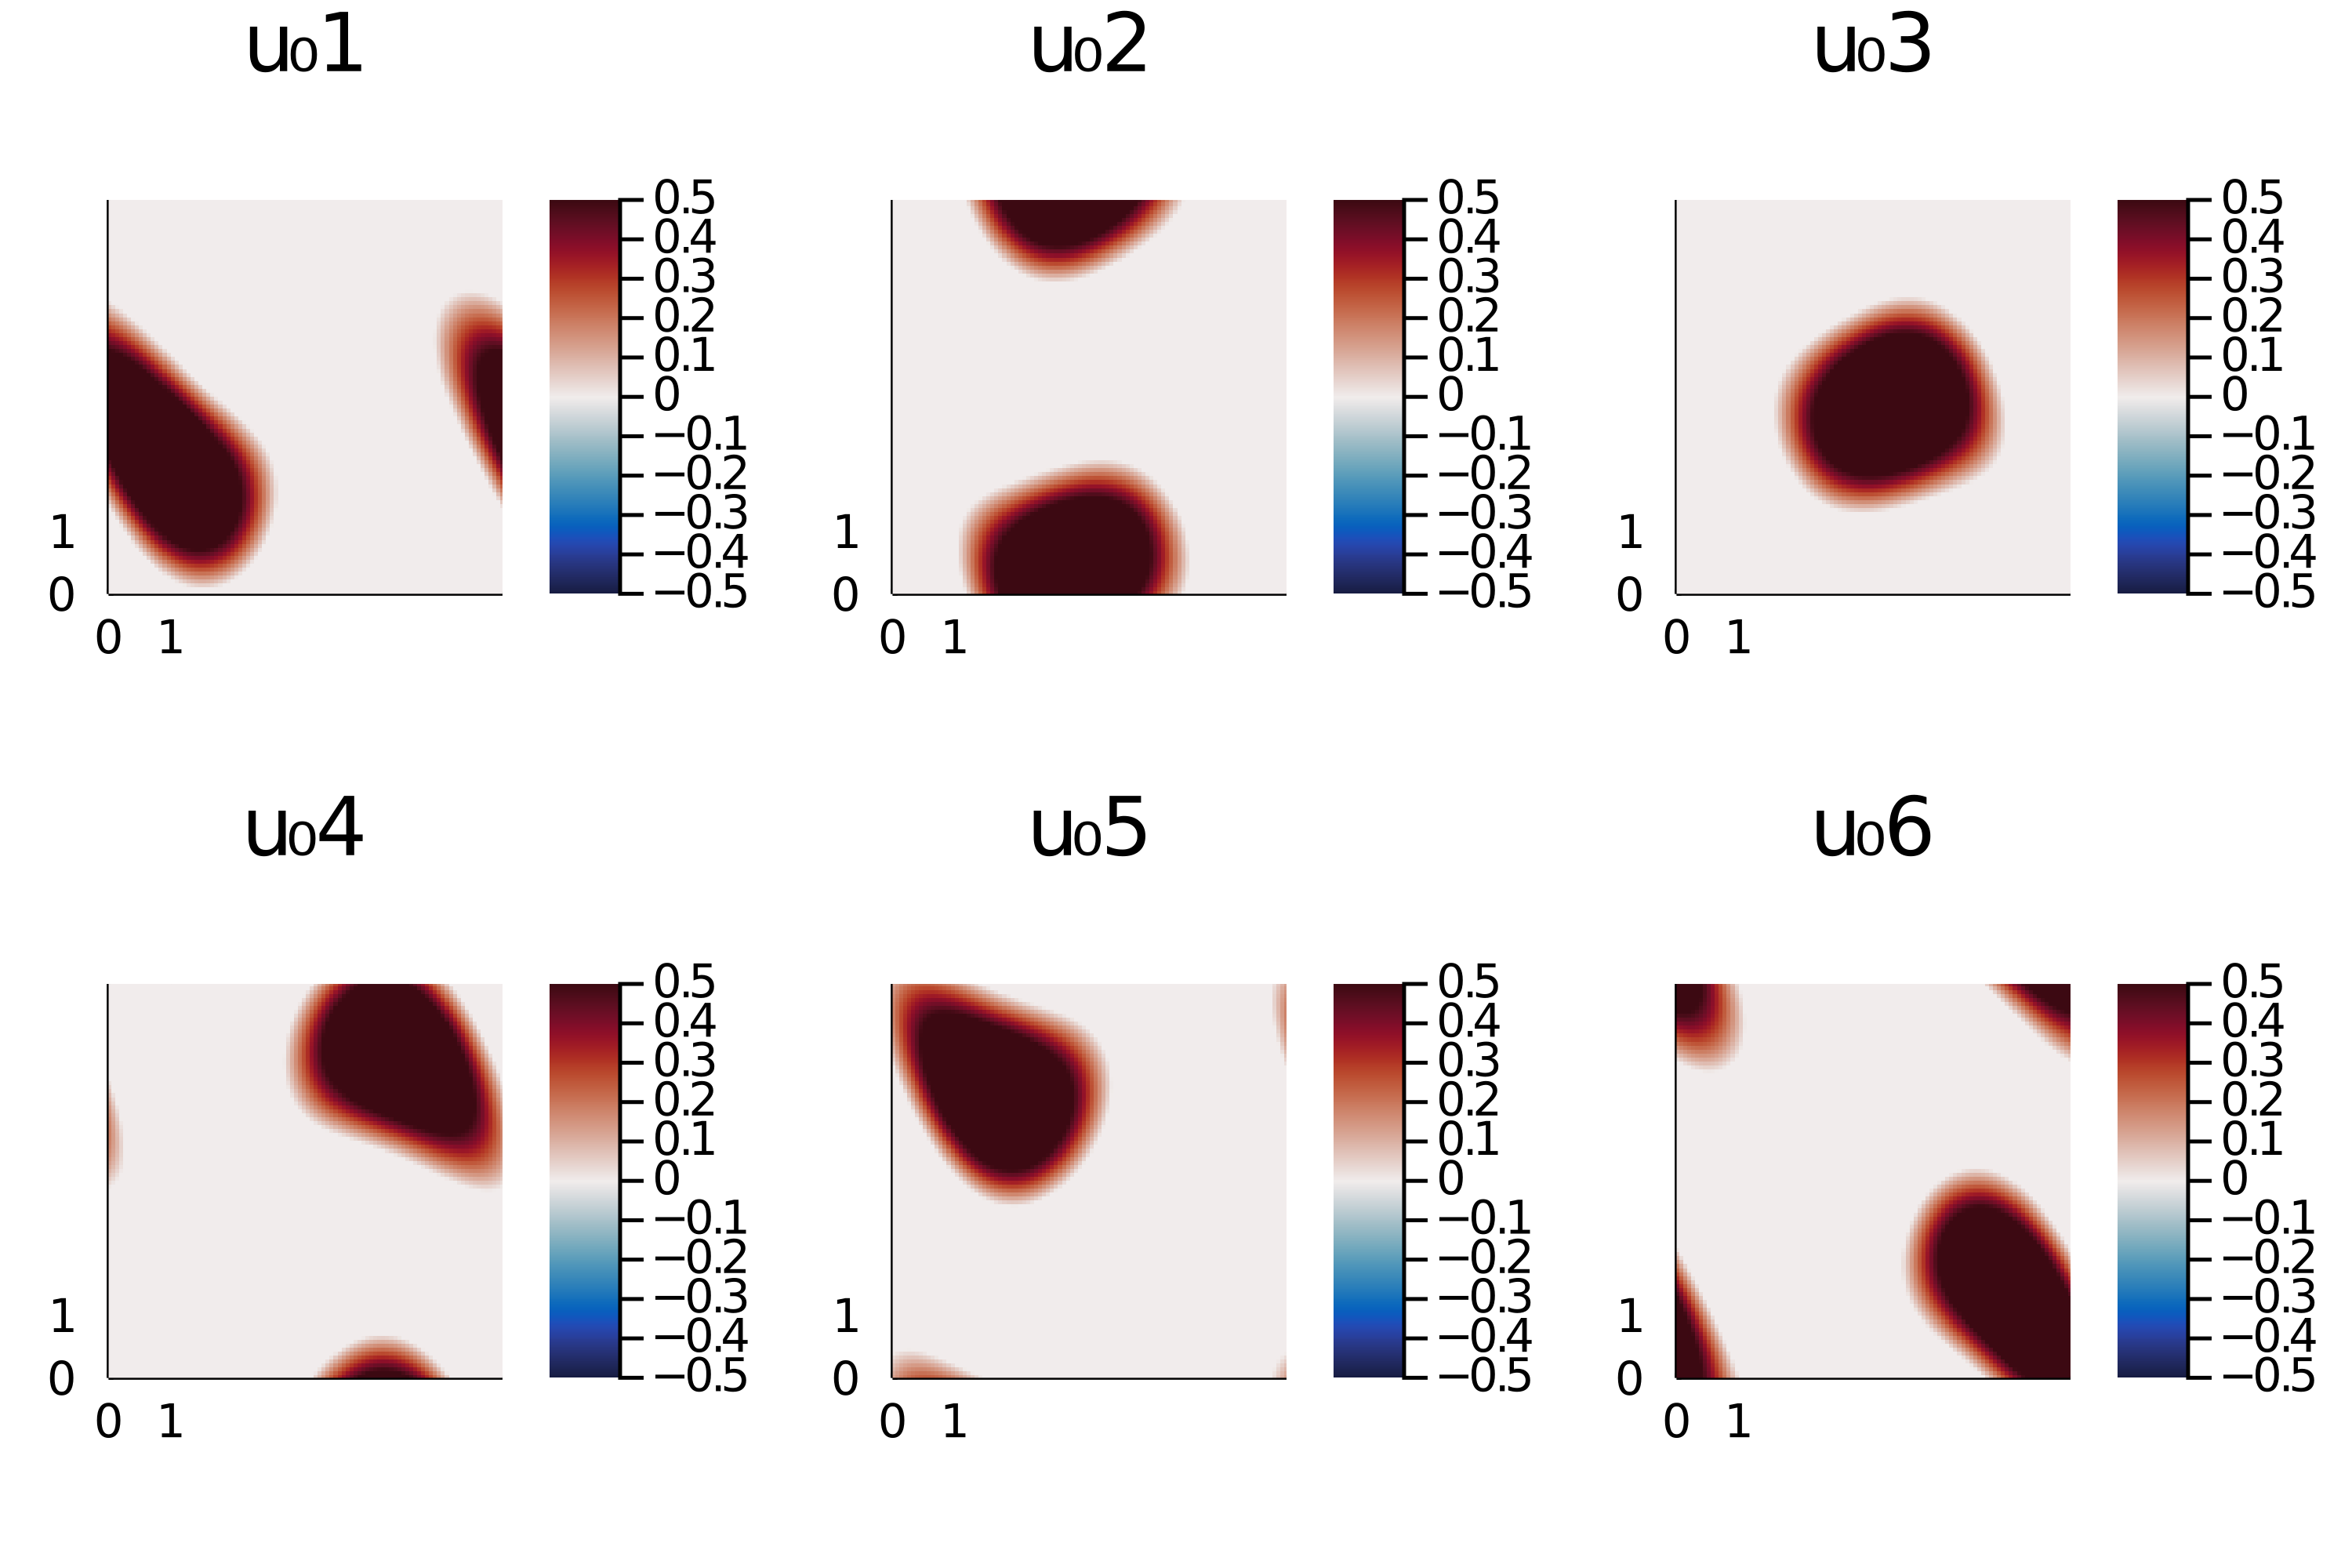

In [29]:
first         = plot_u(ctx, S[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, S[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, S[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, S[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, S[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, S[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

In [30]:
Sϵ = SEBA(uϵs)

9801×6 Array{Float64,2}:
  0.0        -0.0  0.0  -0.0  -0.0  0.52795
  0.0        -0.0  0.0  -0.0  -0.0  0.465185
  0.0        -0.0  0.0  -0.0  -0.0  0.509861
  0.0        -0.0  0.0  -0.0  -0.0  0.444623
  0.0        -0.0  0.0  -0.0  -0.0  0.398532
  0.0        -0.0  0.0  -0.0  -0.0  0.375731
  0.0        -0.0  0.0  -0.0  -0.0  0.328631
  0.0        -0.0  0.0  -0.0  -0.0  0.303912
  0.0167976  -0.0  0.0  -0.0  -0.0  0.256105
  0.0560887  -0.0  0.0  -0.0  -0.0  0.229726
  0.0905514  -0.0  0.0  -0.0  -0.0  0.181649
  0.130967   -0.0  0.0  -0.0  -0.0  0.153971
  0.164285   -0.0  0.0  -0.0   0.0  0.106005
  ⋮                                 ⋮
 -0.0        -0.0  0.0   0.0   0.0  0.799442
 -0.0        -0.0  0.0   0.0  -0.0  0.813761
 -0.0        -0.0  0.0   0.0  -0.0  0.822017
 -0.0        -0.0  0.0  -0.0  -0.0  0.823882
 -0.0        -0.0  0.0  -0.0  -0.0  0.819109
 -0.0        -0.0  0.0  -0.0  -0.0  0.807557
 -0.0        -0.0  0.0  -0.0  -0.0  0.789151
  0.0        -0.0  0.0  -0.0  -0.0  0.

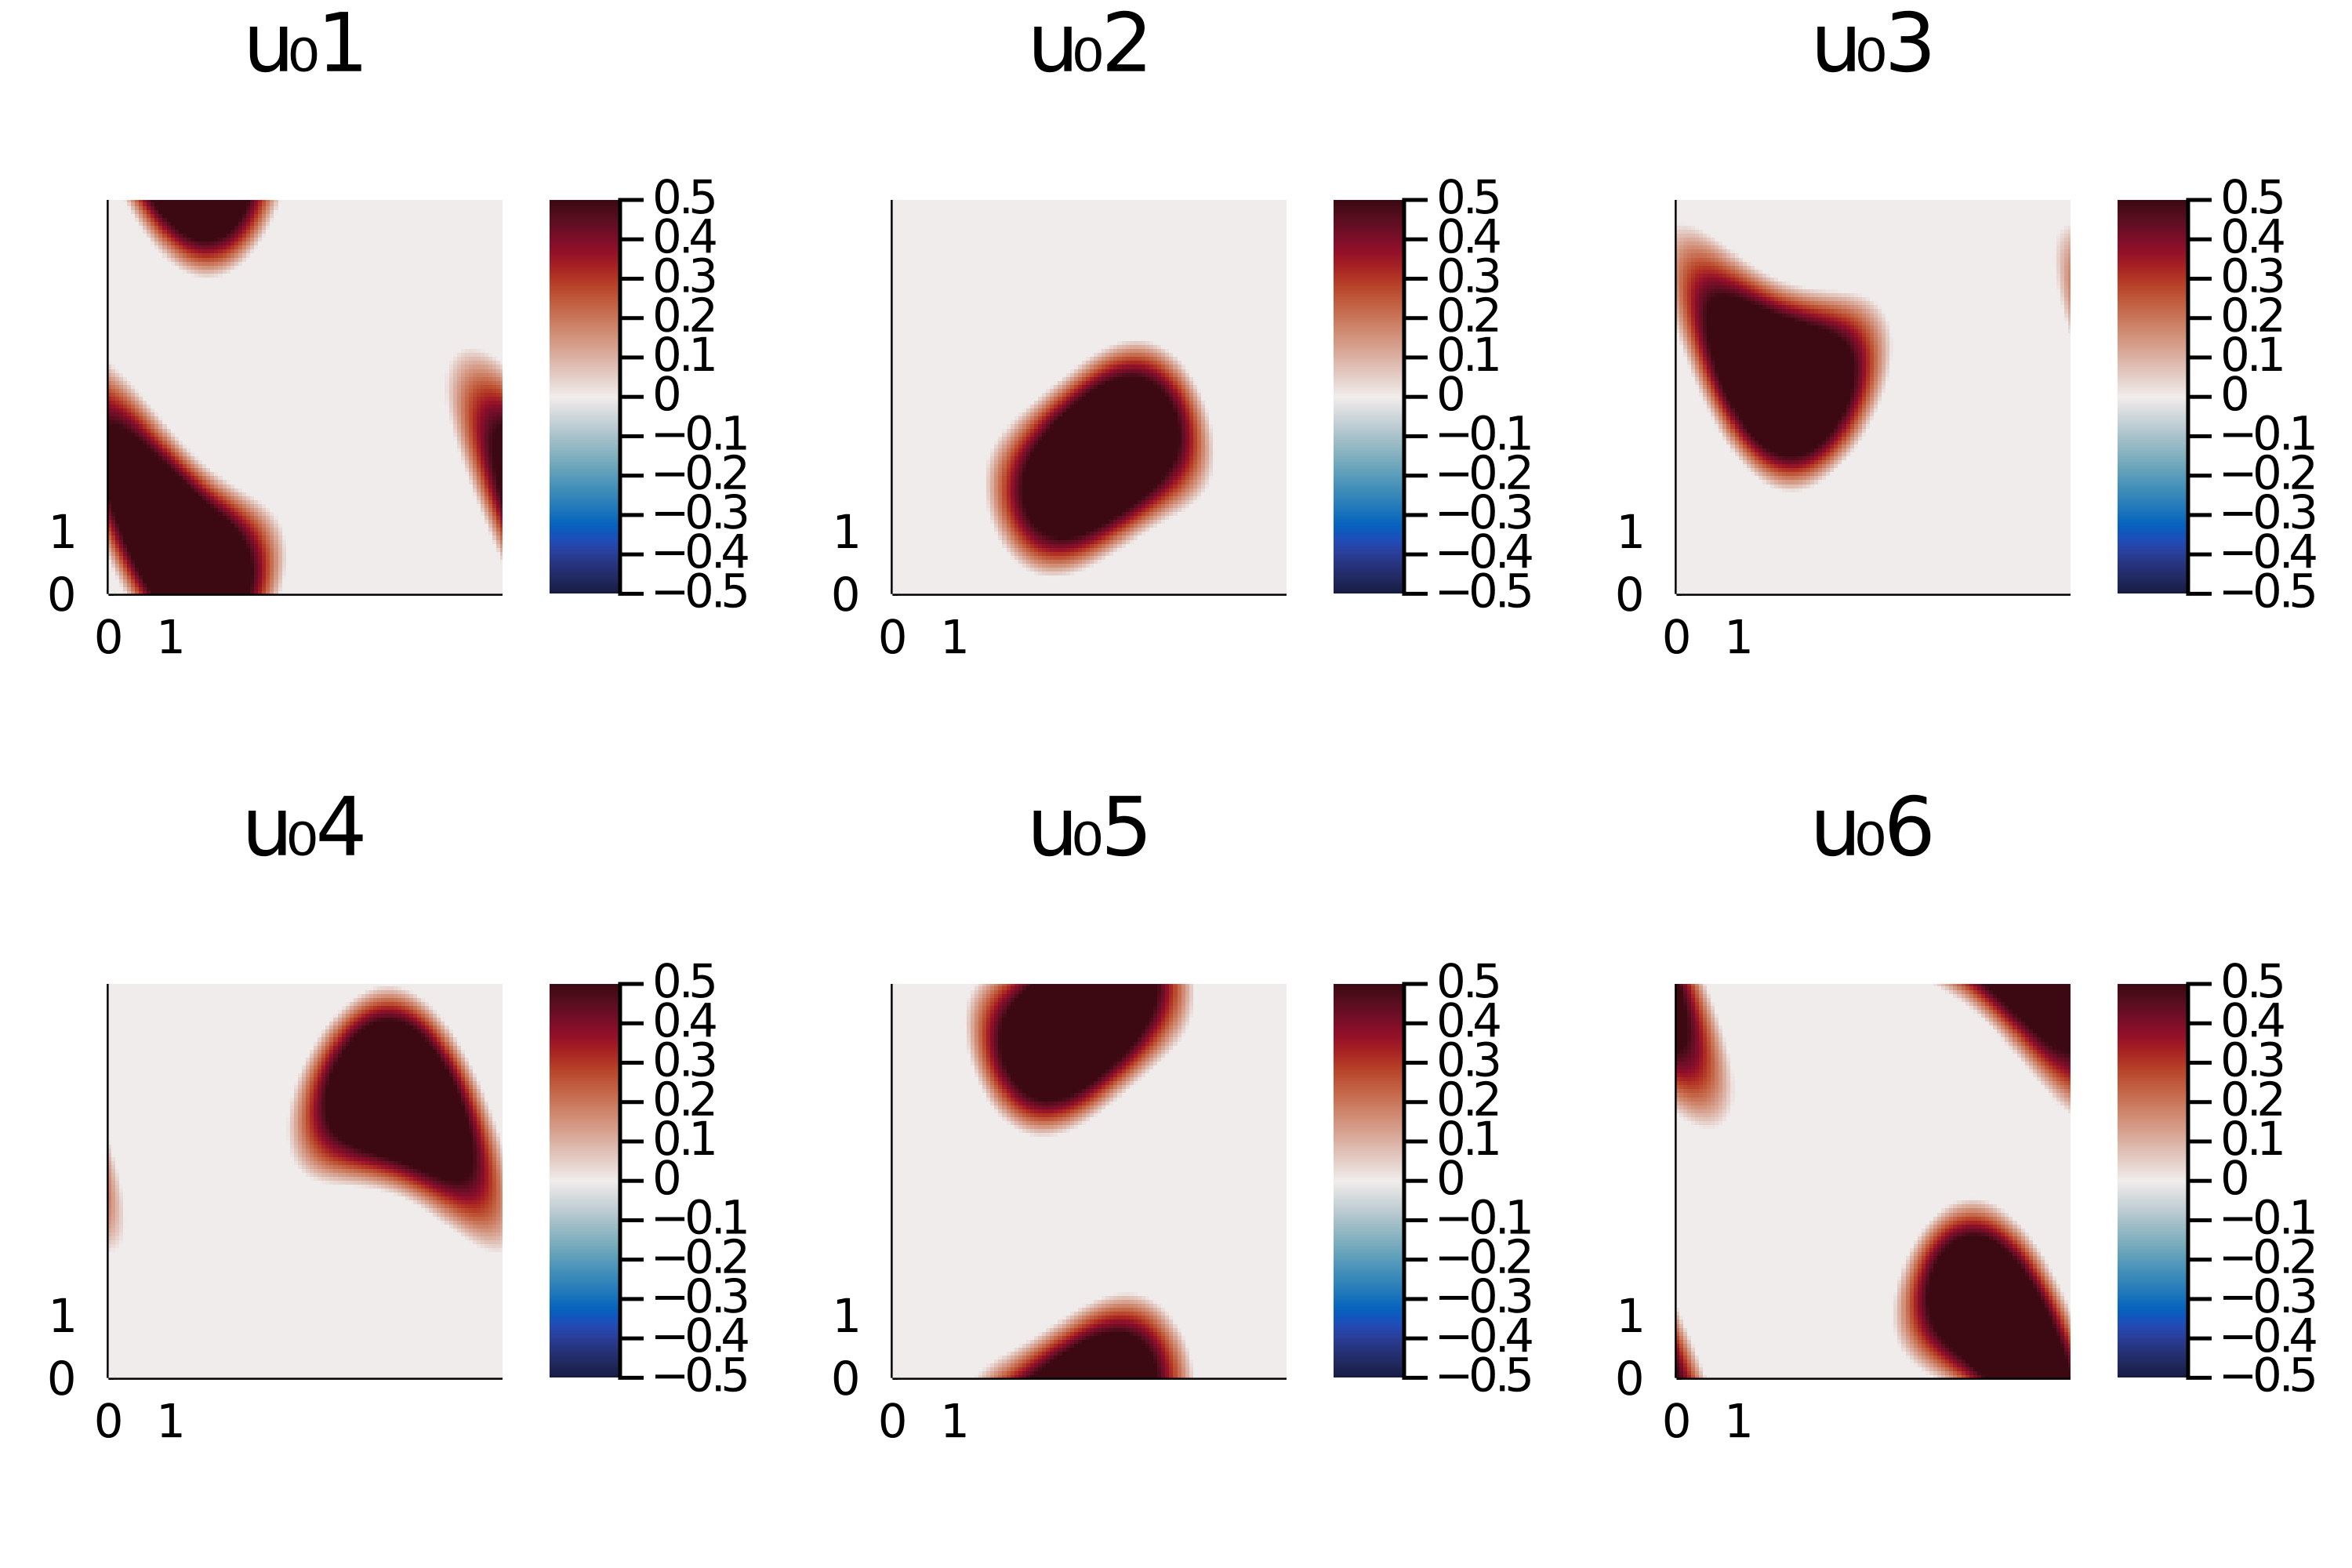

In [31]:
first         = plot_u(ctx, Sϵ[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, Sϵ[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, Sϵ[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, Sϵ[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, Sϵ[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, Sϵ[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)